In [1]:
import numpy as np
import pandas as pd
import os
import shutil
from flashgeotext.geotext import GeoText
import re

In [2]:
import hashlib

def md5hash(s: str):
    return hashlib.md5(s.encode('utf-8')).hexdigest()

In [3]:
record_col="UT (Unique WOS ID)"
outfile = r"C:\Users\radvanyi\PycharmProjects\ZSI_analytics\WOS\wos_extract\wos_records_concat.csv"

In [4]:
wos = pd.read_csv(outfile, sep="\t",low_memory=False)
print(f'Number of initial records: {len(wos)}')
metrix = pd.read_excel("sm_journal_classification.xlsx", sheet_name="Journal_Classification")


metrix = metrix.set_index([c for c in metrix.columns if "issn" not in c]).stack().reset_index()
metrix = metrix.rename(columns={'level_6':"issn_type", 0:"issn"})
metrix["issn"]=metrix["issn"].str.replace("-","").str.lower().str.strip()

wos["issn"] = wos["ISSN"].str.replace("-","").str.lower().str.strip()
wos["eissn"] = wos["eISSN"].str.replace("-","").str.lower().str.strip()
wos = wos.set_index([c for c in wos.columns if "issn" not in c]).stack().reset_index()
wos = wos.rename(columns={'level_71':"issn_var", 0:"issn"})

wos_merge = wos.merge(metrix, on="issn", how="left")
wos = wos_merge.sort_values(by="issn_var",ascending=False).drop_duplicates(subset=record_col)

# drop entries not indexed by metrix
wos = wos[~wos["Domain_English"].isna()]
# drop duplicates (based on doi)
wos = wos[~((~wos["DOI"].isna())&(wos["DOI"].duplicated(False)))]
wos = wos.drop_duplicates(subset=["Publication Type","Document Type","Authors","Article Title","Source Title","Publication Year"])
wos = wos[((wos["Publication Year"]<2023) & (~wos['Domain_English'].isna()))]
print(f'Number of filtered records: {len(wos)}')

Number of initial records: 41511
Number of filtered records: 35663


In [5]:
wos[["Article Title","Keywords Plus","Author Keywords"]].sample(100)

Article Title   
60737  Beauty3DFaceNet: Deep geometry and texture fus...  \
61738  Document Neural Autoregressive Distribution Es...   
47201  Discriminative feature representation for Nois...   
65760  Large-scale hydrological modeling in a multi-o...   
19959             Location Prediction in Social Networks   
...                                                  ...   
41680       Altered global brain signal in schizophrenia   
27626  Prediction of Surface Topography at the End of...   
44966  Cascading Failure Analysis of Cyber Physical P...   
38077  Data analysis and mining of traffic features b...   
67492  TBN: Convolutional Neural Network with Ternary...   

                                           Keywords Plus   
60737                   FACE; COMPUTATION; BEAUTY; SHAPE  \
61738                                                NaN   
47201  NATURAL SCENE STATISTICS; SPARSE REPRESENTATIO...   
65760   GROUNDWATER DEPLETION; EVAPOTRANSPIRATION; WATER   
19959                                                NaN   
...                                                  ...   
41680  RESTING-STATE FMRI; FUNCTIONAL CONNECTIVITY MR...   
27626                                                NaN   
44966  SELF-ORGANIZED CRITICALITY; COMMUNICATION; STA...   
38077                                                NaN   
67492                                                NaN   

                                         Author Keywords  
60737  3D facial attractiveness prediction; Deep lear...  
61738  Neural networks; Deep learning; Topic models; ...  
47201  Discriminative feature representation (DFR); N...  
65760  Large scale modeling; Multi-objective calibrat...  
19959                                                NaN  
...                                                  ...  
41680  resting-state; global signal; psychiatric illness  
27626    Wear Modeling; Sliding Wear; Surface Topography  
44966  Cascading failure; control threshold; cyber ph...  
38077  data mining; GPS trajectory; Internet of Thing...  
67492  CNN; TBN; Acceleration; Compression; Binary op...  

[100 rows x 3 columns]

In [6]:
kw_df = pd.DataFrame()
for c in ["Keywords Plus","Author Keywords"]:
    kwp = wos.groupby(record_col)[c].apply(lambda x: x.str.split(';')).explode().str.strip().str.upper()
    kwp.name = 'keyword_all'
    kw_df = pd.concat([kwp.reset_index(),kw_df],ignore_index=True)
kw_df = kw_df[~kw_df["keyword_all"].isna()].copy().drop(columns="level_1").drop_duplicates()
kw_df["keyword_all"] = kw_df["keyword_all"].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x))
kw_df.head(100)

UT (Unique WOS ID)                 keyword_all
0    WOS:000208863600013        COMPARATIVE GENOMICS
1    WOS:000208863600013                     ANAMMOX
2    WOS:000208863600013    KUENENIA STUTTGARTIENSIS
3    WOS:000208863600013                METAGENOMICS
4    WOS:000208863600013          ENRICHMENT CULTURE
..                   ...                         ...
97   WOS:000209724300006               VIRTUAL DISKS
98   WOS:000209724300006      HETEROGENEOUS SERVICES
99   WOS:000209810700046  CORROSION CHARACTERIZATION
100  WOS:000209810700046          FEATURE EXTRACTION
101  WOS:000209810700046         PULSED EDDY CURRENT

[100 rows x 2 columns]

In [7]:
wos_kwd_concat = kw_df.groupby(record_col, as_index=False).agg({'keyword_all': '; '.join})
wos_kwd_concat.head()

UT (Unique WOS ID)                                        keyword_all
0  WOS:000208863600013  COMPARATIVE GENOMICS; ANAMMOX; KUENENIA STUTTG...
1  WOS:000208863600266  ANME; PYROSEQUENCING; AOM; COMMUNITY STRUCTURE...
2  WOS:000208863900217  DEFAULT MODE NETWORK; EFFECTIVE CONNECTIVITY; ...
3  WOS:000208972600008  BRAIN-MACHINE INTERFACE ; FIELD-PROGRAMMABLE G...
4  WOS:000209043200014  CYANOBACTERIA BLOOM; DRINKING WATER TREATMENT;...

In [8]:
wos.columns

Index(['Publication Type', 'Authors', 'Book Authors', 'Book Editors',
       'Book Group Authors', 'Author Full Names', 'Book Author Full Names',
       'Group Authors', 'Article Title', 'Source Title', 'Book Series Title',
       'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title',
       'Conference Date', 'Conference Location', 'Conference Sponsor',
       'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses',
       'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Name Preferred',
       'Funding Text', 'Cited References', 'Cited Reference Count',
       'Times Cited, WoS Core', 'Times Cited, All Databases',
       '180 Day Usage Count', 'Since 2013 Usage Count', 'Publisher',
       'Publisher City', 'Publisher Address', 'ISSN', 'eISSN', 'ISBN',
       'Journal Abbreviation', 'Journal ISO Abbreviation', 'Publication Date',
       'Publication Year', 'Volume', 'Issue', 'Pa

In [9]:
geotext = GeoText()

def extract_location(input_text, key='countries'):
    anomalies = {"Malta":"Malta",
                 "Mongolia":"Mongolia",
                 "Quatar":"Qatar",
                 "Qatar":"Qatar",
                 "Ethiop":"Ethiopia",
                 "Nigeria":"Nigeria",
                 "BELAR":"Belarus",
                 "Venezuela":"Venezuela",
                 "Cyprus":"Cyprus",
                 "Ecuador":"Ecuador",
                 "U Arab":"United Arab Emirates",
                 "Syria":"Syria",
                 "Uganda":"Uganda",
                 "Yemen":"Yemen",
                 "Mali":"Mali",
                 "Senegal":"Senegal",
                 "Vatican":"Vatican",
                 "Uruguay":"Uruguay",
                 "Panama":"Panama",
                 "Fiji":"Fiji",
                 "Faroe":"Faroe Islands",
                 "Macedonia":"Macedonia",
                 'Mozambique':'Mozambique',
                 "Kuwait":"Kuwait",
                 "Libya":"Libya",
                 "Turkiy":"Turkey",
                 "Liberia":"Liberia",
                 "Namibia":"Namibia",
                 "Ivoire":"Ivory Coast",
                 "Guatemala":"Gutemala",
                 "Paraguay":"Paraguay",
                 "Honduras":"Honduras",
                 "Nicaragua":"Nicaragua",
                 "Trinidad":"Trinidad & Tobago",
                 "Liechtenstein":"Liechtenstein",
                 "Greenland":"Denmark"}

    extracted = geotext.extract(input_text=input_text)
    found = extracted[key].keys()
    if len(sorted(found))>0:
        return sorted(found)[0]
    elif key=='countries':
        for i  in ['Scotland','Wales','England', 'N Ireland']:
            if i in input_text:
                return 'United Kingdom'
        for j in anomalies.keys():
            if j in input_text:
                return anomalies.get(j)
    else:
        return None

with open('../eu_members.txt',"r") as f:
    eu_countries=f.readline().split(",")
    eu_countries=[i.strip() for i in eu_countries]

def country_type(country):
    if country in eu_countries:
        return "EU"
    elif country=="China":
        return "China"
    elif country in ["Switzerland", 'Norway','United Kingdom']:
        return "Non-EU associate"
    else:
        return "Other"


In [10]:
locations = wos.groupby(record_col)["Addresses"].apply(lambda x: x.str.split('[')).explode().reset_index().drop(columns="level_1")
locations = locations[locations["Addresses"]!=""].copy()
locations["Address"] = locations["Addresses"].apply(lambda x:x.split("]")[-1])
locations["Authors_of_address"] = locations["Addresses"].apply(lambda x:x.split("]")[0])
locations["Country"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='countries'))
locations["City"]=locations['Address'].apply(lambda x: extract_location(input_text=x, key='cities'))
locations["Country_Type"] = locations["Country"].apply(lambda x: country_type(x))

In [11]:
scope_types = ["EU","China","Non-EU associate"]
locations=locations[locations["Country_Type"].isin(scope_types)]

In [12]:
univ_locations = locations[[record_col,"Address","Country","City","Country_Type"]].copy()
univ_locations["Institution"] = univ_locations["Address"].apply(lambda x: x.split(",")[0])
univ_locations = univ_locations.drop_duplicates()
univ_locations.head()

UT (Unique WOS ID)                                            Address   
1  WOS:000208863600013   Radboud Univ Nijmegen, Dept Microbiol, Inst W...  \
2  WOS:000208863600013   Zhejiang Univ, Dept Environm Engn, Hangzhou 3...   
3  WOS:000208863600013   Radboud Univ Nijmegen, Dept Mol Biol, Nijmege...   
4  WOS:000208863600013   Delft Univ Technol, Dept Biotechnol, Delft, N...   
6  WOS:000208863600266   Univ Bergen, Ctr Geobiol, Dept Biol, N-5020 B...   

       Country      City      Country_Type             Institution  
1  Netherlands  Nijmegen                EU   Radboud Univ Nijmegen  
2        China  Hangzhou             China           Zhejiang Univ  
3  Netherlands       Mol                EU   Radboud Univ Nijmegen  
4  Netherlands     Delft                EU      Delft Univ Technol  
6       Norway    Bergen  Non-EU associate             Univ Bergen

In [13]:
author_locations = locations.groupby([record_col,"Country","Country_Type"])["Authors_of_address"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_3")
author_locations["Author_name"] = author_locations["Authors_of_address"].str.strip()
author_locations = author_locations.drop(columns="Authors_of_address")
author_locations["author_str_id"] = author_locations["Author_name"].apply(lambda x:''.join(filter(str.isalnum, x.lower())))
author_locations["author_str_id"] = author_locations["author_str_id"].apply(md5hash)
author_locations = author_locations.drop(columns="Author_name")
author_locations.head()

UT (Unique WOS ID)      Country Country_Type   
0  WOS:000208863600013        China        China  \
1  WOS:000208863600013  Netherlands           EU   
2  WOS:000208863600013  Netherlands           EU   
3  WOS:000208863600013  Netherlands           EU   
4  WOS:000208863600013  Netherlands           EU   

                      author_str_id  
0  54c7bc6fe9b77434ca1bf04d763d843b  
1  6a775fcd8d11fcb084671b8cae4d6305  
2  aa6accfdf7626441fe9191636dab4c35  
3  b707b51d1ca3b5aa76de6ce6df20e6e4  
4  df81f9da6c8f5c968c16ef0aab1bb8f9

In [14]:
author_locations[author_locations['author_str_id'].duplicated(False)]

UT (Unique WOS ID)         Country      Country_Type   
0       WOS:000208863600013           China             China  \
4       WOS:000208863600013     Netherlands                EU   
6       WOS:000208863600013     Netherlands                EU   
7       WOS:000208863600266           China             China   
13      WOS:000208863900217           China             China   
...                     ...             ...               ...   
441911  WOS:000951829800021           China             China   
441912  WOS:000951829800021     Netherlands                EU   
441913  WOS:000952055000007           China             China   
441914  WOS:000952055000007           China             China   
441916  WOS:000952055000007  United Kingdom  Non-EU associate   

                           author_str_id  
0       54c7bc6fe9b77434ca1bf04d763d843b  
4       df81f9da6c8f5c968c16ef0aab1bb8f9  
6       df81f9da6c8f5c968c16ef0aab1bb8f9  
7       5dfb4f0408a2cc8b7f36f5516938b62c  
13      00e44aa0a23a3fc9571b1053a4453a54  
...                                  ...  
441911  fc15bf7c800877e1c33f4a7397840faa  
441912  6b8763361150d7c3ceecf9eca9efd83b  
441913  80231479c1502ce8649717236023b6c9  
441914  0af23824e538b0816c19239079d58c77  
441916  b77dd6bc0ae30a2f96d43eebb1b3d89a  

[387172 rows x 4 columns]

In [15]:
author_primary_region = author_locations.sort_values(by="Country_Type").drop_duplicates(subset=[record_col,"author_str_id"])
# author_primary_region

china=author_primary_region[author_primary_region["Country_Type"]=="China"][record_col].unique()
eu=author_primary_region[author_primary_region["Country_Type"]=="EU"][record_col].unique()
assoc=author_primary_region[author_primary_region["Country_Type"]=="Non-EU associate"][record_col].unique()


# records that have distinct authors with different country affiliations
valid_scope = wos[((wos[record_col].isin(china))
         &
         ((wos[record_col].isin(eu))
         |
         (wos[record_col].isin(assoc))))][record_col].unique()

In [16]:
author_primary_region.head()

UT (Unique WOS ID) Country Country_Type   
0       WOS:000208863600013   China        China  \
304939  WOS:000648878200015   China        China   
304935  WOS:000648805900001   China        China   
304934  WOS:000648805900001   China        China   
304933  WOS:000648805900001   China        China   

                           author_str_id  
0       54c7bc6fe9b77434ca1bf04d763d843b  
304939  043a846fd3ea05c308e9944b984b8d8f  
304935  4132592fad8ecaa0bc99a8148c348f45  
304934  0bcfdc30b9929c5513eaabfe484ffd26  
304933  3d5c738679e81c68cc67a06ecc686851

In [17]:
print(f'Number of records: {len(wos)}')
print(f'Number of valid cooperation records: {len(valid_scope)}')

Number of records: 35663
Number of valid cooperation records: 31861


In [18]:
wos = wos[wos[record_col].isin(valid_scope)]
locations = locations[locations[record_col].isin(valid_scope)]
univ_locations = univ_locations[univ_locations[record_col].isin(valid_scope)]
author_locations = author_locations[author_locations[record_col].isin(valid_scope)]
author_primary_region = author_locations[author_locations[record_col].isin(valid_scope)]

In [19]:
affiliations = wos.groupby(record_col)["Affiliations"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
affiliations["Affiliations"] = affiliations["Affiliations"].str.strip().str.upper().fillna("UNKNOWN")
affiliations = affiliations.drop_duplicates()

In [20]:
affiliations["Affiliations"].value_counts()

Affiliations
CHINESE ACADEMY OF SCIENCES                              3623
UNIVERSITY OF LONDON                                     1729
UDICE-FRENCH RESEARCH UNIVERSITIES                       1421
TSINGHUA UNIVERSITY                                      1347
CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE (CNRS)      1330
                                                         ... 
FRESHWATER FISHERIES RESEARCH CENTER, CAFS                  1
HEILONGJIANG RIVER FISHERIES RESEARCH INSTITUTE, CAFS       1
INSTITUTE OF METEOROLOGY & WATER MANAGEMENT                 1
FEDERAL MINISTRY OF HEALTH - ETHIOPIA (FMOH)                1
TANGSHAN UNIVERSITY                                         1
Name: count, Length: 6784, dtype: int64

In [21]:
univ_locations["Institution"].value_counts()

Institution
 Chinese Acad Sci                             3618
 Tsinghua Univ                                1633
 Shanghai Jiao Tong Univ                      1372
 Zhejiang Univ                                1288
 Univ Elect Sci & Technol China                969
                                              ... 
 Ludwig Boltzmann Inst Clin Forens Imaging       1
 Royal Brampton Hosp                             1
 Inst Spacecraft Syst Engn CAST                  1
 Sevalo Construct Machinery Remfg Co Ltd         1
 Int Digital Econ Acad                           1
Name: count, Length: 14546, dtype: int64

In [22]:
univ_locations[record_col].nunique()

31861

In [23]:
affiliations[record_col].nunique()

31861

In [24]:
univ_locations["Institution"].value_counts().sum()

138559

In [25]:
affiliations["Affiliations"].value_counts().sum()

181832

In [26]:
wos_cat = wos.groupby(record_col)["WoS Categories"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_cat["WoS Categories"].value_counts()

WoS Categories
 Engineering, Electrical & Electronic        6066
Computer Science, Artificial Intelligence    4859
Computer Science, Information Systems        3740
 Telecommunications                          3304
Engineering, Electrical & Electronic         2451
                                             ... 
 Criminology & Penology                         1
Area Studies                                    1
Materials Science, Paper & Wood                 1
 Emergency Medicine                             1
 Geology                                        1
Name: count, Length: 415, dtype: int64

In [27]:
wos_areas = wos.groupby(record_col)["Research Areas"].apply(lambda x: x.str.split(';')).explode().reset_index().drop(columns="level_1")
wos_areas["Research Areas"] = wos_areas["Research Areas"].str.strip()
wos_areas["Research Areas"].value_counts()

Research Areas
Engineering                                  12815
Computer Science                             12386
Telecommunications                            3577
Imaging Science & Photographic Technology     1949
Environmental Sciences & Ecology              1887
                                             ...  
Music                                            1
Asian Studies                                    1
Cultural Studies                                 1
Area Studies                                     1
Emergency Medicine                               1
Name: count, Length: 145, dtype: int64

In [29]:
[c for c in wos.columns if "_English" in c]

['Domain_English', 'Field_English', 'SubField_English']

In [30]:
metrix_levels = [c for c in wos.columns if "_English" in c]
for m in metrix_levels:
    wos[m] = wos[m].replace({"article-level classification":"Miscellaneous"})


In [ ]:
wos

In [ ]:
metrix_levels

In [39]:
outdir="wos_processed_data"

In [80]:
record_countries = locations[[record_col,"Country"]].drop_duplicates()
record_author_locations = author_locations[[record_col,"author_str_id","Country"]].drop_duplicates()
record_institution = univ_locations[[record_col,"Institution","Country"]].drop_duplicates()
country_types = locations[["Country","Country_Type"]].drop_duplicates()

In [81]:
country_collabs = record_countries.merge(record_countries, on=record_col)
country_collabs = country_collabs[country_collabs["Country_x"]!=country_collabs["Country_y"]]
country_collabs["weight"] = 0.5

In [82]:
inst_collabs = record_institution.merge(record_institution, on=record_col)
inst_collabs = inst_collabs[inst_collabs["Institution_x"]!=inst_collabs["Institution_y"]]
inst_collabs["weight"] = 0.5

In [85]:
wos.columns

Index(['Publication Type', 'Authors', 'Book Authors', 'Book Editors',
       'Book Group Authors', 'Author Full Names', 'Book Author Full Names',
       'Group Authors', 'Article Title', 'Source Title', 'Book Series Title',
       'Book Series Subtitle', 'Language', 'Document Type', 'Conference Title',
       'Conference Date', 'Conference Location', 'Conference Sponsor',
       'Conference Host', 'Author Keywords', 'Keywords Plus', 'Abstract',
       'Addresses', 'Affiliations', 'Reprint Addresses', 'Email Addresses',
       'Researcher Ids', 'ORCIDs', 'Funding Orgs', 'Funding Name Preferred',
       'Funding Text', 'Cited References', 'Cited Reference Count',
       'Times Cited, WoS Core', 'Times Cited, All Databases',
       '180 Day Usage Count', 'Since 2013 Usage Count', 'Publisher',
       'Publisher City', 'Publisher Address', 'ISSN', 'eISSN', 'ISBN',
       'Journal Abbreviation', 'Journal ISO Abbreviation', 'Publication Date',
       'Publication Year', 'Volume', 'Issue', 'Pa

In [91]:
drop_cols = [ws for ws in wos.columns if (("uthor" in ws or "ddress" in ws or "ORCID" in
                                           ws or "esearcher" in ws or "ditor" in ws or "name" in ws or 'SEQ' in ws) and "eyword" not in ws)]
drop_cols

['Authors',
 'Book Authors',
 'Book Editors',
 'Book Group Authors',
 'Author Full Names',
 'Book Author Full Names',
 'Group Authors',
 'Addresses',
 'Reprint Addresses',
 'Email Addresses',
 'Researcher Ids',
 'ORCIDs',
 'Publisher Address',
 '2.00 SEQ']

In [88]:
os.makedirs(outdir, exist_ok=True)

wos.drop(columns=drop_cols).to_excel(f"{outdir}/wos_processed.xlsx", index=False)

record_countries.to_excel(f"{outdir}/wos_countries.xlsx", index=False)

record_author_locations.to_excel(f"{outdir}/wos_author_locations.xlsx", index=False)

record_institution.to_excel(f"{outdir}/wos_institution_locations.xlsx", index=False)

kw_df.to_excel(f"{outdir}/wos_keywords.xlsx", index=False)

country_types.to_excel(f"{outdir}/wos_country_types.xlsx", index=False)

In [92]:
wos.drop(columns=drop_cols).to_csv(f"{outdir}/wos_processed.csv", index=False, sep='\t')

record_countries.to_csv(f"{outdir}/wos_countries.csv", index=False, sep='\t')

record_author_locations.to_csv(f"{outdir}/wos_author_locations.csv", index=False, sep='\t')

record_institution.to_csv(f"{outdir}/wos_institution_locations.csv", index=False, sep='\t')

kw_df.to_csv(f"{outdir}/wos_keywords.csv", index=False, sep='\t')

country_types.to_csv(f"{outdir}/wos_country_types.csv", index=False, sep='\t')

inst_collabs.to_csv(f"{outdir}/wos_inst_collabs.csv", index=False, sep='\t')

country_collabs.to_csv(f"{outdir}/wos_country_collabs.csv", index=False, sep='\t')

In [ ]:
# Basic network layout

# Simple NLP part

<Axes: ylabel='Frequency'>

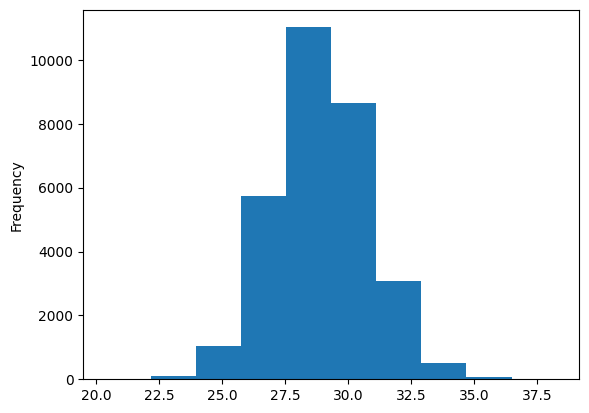

In [32]:
import spacy

nlp = spacy.load("en_core_web_lg")
wos_nlp = wos.merge(wos_kwd_concat, on=record_col)
wos_nlp["Document"] = wos_nlp["Article Title"].str.cat(wos_nlp[["Abstract", "keyword_all"]].fillna(""), sep=' - ')
# wos_kwd_test["BERT_KWDS"] = wos_kwd_test["Document"].map(kwd_extract)

vectors = list()
vector_norms = list()

for doc in nlp.pipe(wos_nlp['Document'].astype('unicode').values, batch_size=300,
                    n_process=4):
    vectors.append(doc.vector)
    vector_norms.append(doc.vector_norm)

wos_nlp['vector'] = vectors
wos_nlp['vector_norm'] = vector_norms
wos_nlp['vector_norm'].plot(kind="hist")

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

vector_data = pd.DataFrame(wos_nlp["vector"].to_list(), index=wos_nlp[record_col]).reset_index()
vector_data.head()

labels = vector_data.values[:, 0]
record_vectors = vector_data.values[:, 1:]

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42, metric='cosine')
tnse_2d = tsne_model.fit_transform(record_vectors)
tnse_data = pd.DataFrame(tnse_2d, index=labels).reset_index()
tnse_data.columns = [record_col, "TNSE-X", "TNSE-Y"]
tnse_data.head()

UT (Unique WOS ID)      TNSE-X     TNSE-Y
0  WOS:000641589600020  131.783783  -4.202979
1  WOS:000590197400003   74.897812  89.280334
2  WOS:000510863400004   84.939049  23.416033
3  WOS:000403039400031  -39.527546  54.230900
4  WOS:000439363600016  -59.109379  72.877693

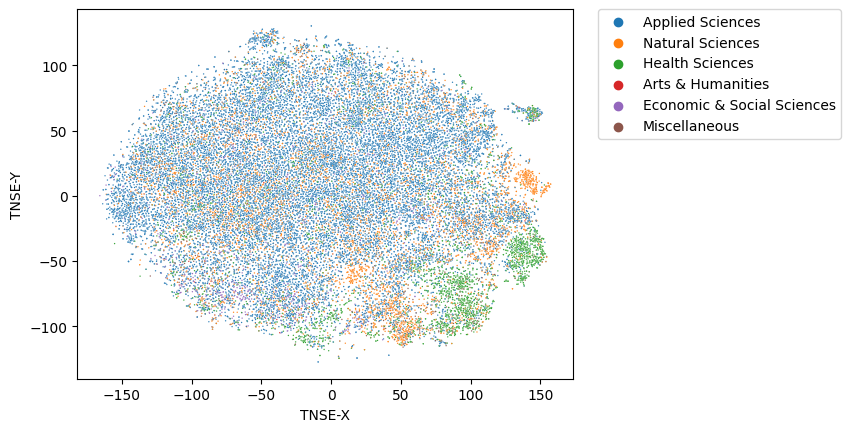

In [36]:
wos_plot = wos_nlp.merge(tnse_data, on=record_col)

g = sns.scatterplot(wos_plot[wos_plot["Domain_English"] != 'article-level classification'], x="TNSE-X", y="TNSE-Y",
                    hue='Domain_English', s=1)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
wos_plot.head()
wos_nlp = wos_plot[[record_col, "Document", "keyword_all", "TNSE-X", "TNSE-Y"]]


In [40]:

wos_nlp.to_excel(f"{outdir}/wos_nlp.xlsx", index=False)

In [93]:
wos_nlp.to_csv(f"{outdir}/wos_nlp.csv", index=False, sep='\t')

In [37]:
wos_nlp.columns

Index(['UT (Unique WOS ID)', 'Document', 'keyword_all', 'TNSE-X', 'TNSE-Y'], dtype='object')

<Axes: ylabel='Frequency'>

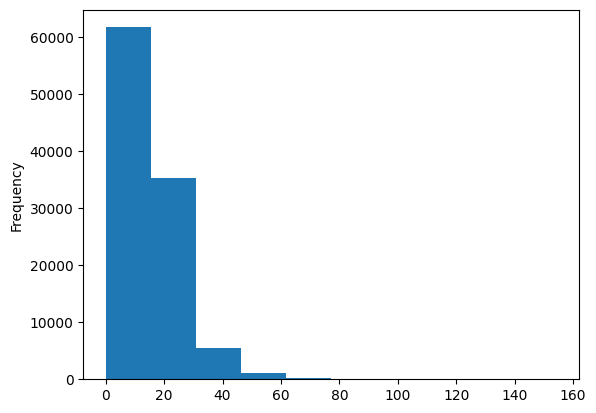

In [94]:
import spacy

nlp = spacy.load("en_core_web_lg")
kwd_nlp = pd.DataFrame(kw_df["keyword_all"].drop_duplicates())
# wos_kwd_test["BERT_KWDS"] = wos_kwd_test["Document"].map(kwd_extract)

vectors = list()
vector_norms = list()

for doc in nlp.pipe(kwd_nlp['keyword_all'].astype('unicode').values, batch_size=300,
                    n_process=4):
    vectors.append(doc.vector)
    vector_norms.append(doc.vector_norm)

kwd_nlp['vector'] = vectors
kwd_nlp['vector_norm'] = vector_norms
kwd_nlp['vector_norm'].plot(kind="hist")

In [95]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
# % matplotlib inline

vector_data = pd.DataFrame(kwd_nlp["vector"].to_list(), index=kwd_nlp["keyword_all"]).reset_index()
vector_data.head()

labels = vector_data.values[:, 0]
record_vectors = vector_data.values[:, 1:]

tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, random_state=42, metric='cosine')
tnse_2d = tsne_model.fit_transform(record_vectors)
tnse_data = pd.DataFrame(tnse_2d, index=labels).reset_index()
tnse_data.columns = [record_col, "TNSE-X", "TNSE-Y"]
tnse_data.head()

UT (Unique WOS ID)      TNSE-X      TNSE-Y
0      COMPARATIVE GENOMICS -114.811630  -43.915569
1                   ANAMMOX    8.044455  100.761032
2  KUENENIA STUTTGARTIENSIS    8.044455  100.761032
3              METAGENOMICS    8.044455  100.761032
4        ENRICHMENT CULTURE  -99.356590  -78.270439

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


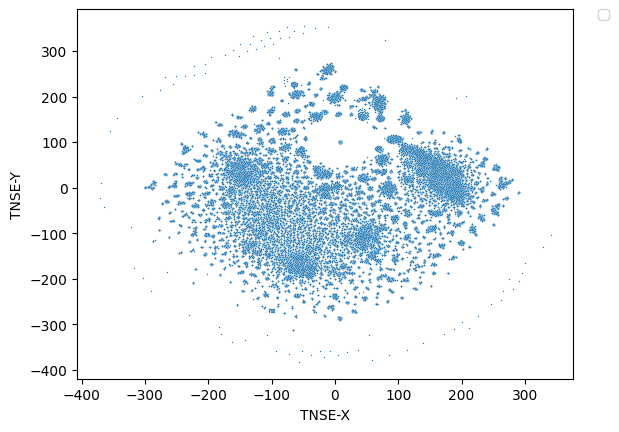

In [96]:
g = sns.scatterplot(tnse_data, x="TNSE-X", y="TNSE-Y", s=1)
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [99]:
wos_nlp.to_csv(f"{outdir}/wos_nlp.csv", index=False, sep='\t')
tnse_data.to_csv(f"{outdir}/kw_nlp.csv", index=False, sep='\t')

wos_nlp.to_excel(f"{outdir}/wos_nlp.xlsx", index=False)
tnse_data.drop_duplicates(subset=record_col).to_excel(f"{outdir}/kw_nlp.xlsx", index=False)